In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import numpy as np

In [14]:
path = 'ray_results'
exps = os.listdir(path)

In [15]:
dfs = []
for folder in exps:
    if folder != ".DS_Store":
        print(os.listdir(os.path.join(path, folder)))
        exp_folders = os.listdir(os.path.join(path, folder))
        for expsf in exp_folders:
            try:
                files = os.listdir(os.path.join(path, folder, expsf))
                file_path = os.path.join(path, folder, expsf, 'result.json')
                with open(file_path, "r") as f:
                    data = json.load(f)
                df = pd.json_normalize(data)
                dfs.append(df)
            except:
                "Not a folder"
results = pd.concat(dfs)
results.to_csv('results_he_checkerboard_ccka.csv')

['basic-variant-state-2024-12-16_13-22-49.json', 'experiment_state-2024-12-16_13-22-49.json', 'train_7699b_00000_0_cclr=0.0100,clusters=2,epochs=500,lambda_co=0.0100,lambda_kao=0.0100,lr=0.1000,mclr=0.0100,train_method=quack,', '.validate_storage_marker', 'tuner.pkl', 'train_7699b_00001_1_cclr=0.0100,clusters=2,epochs=500,lambda_co=0.0100,lambda_kao=0.0100,lr=0.1000,mclr=0.0100,train_method=full,']
['basic-variant-state-2024-12-12_22-00-00.json', 'train_0d2c0_00000_0_cclr=0.0100,clusters=2,epochs=500,lambda_co=0.0100,lambda_kao=0.0100,lr=0.1000,mclr=0.0100,train_method=quack,', 'experiment_state-2024-12-12_22-00-00.json', '.validate_storage_marker', 'train_0d2c0_00001_1_cclr=0.0100,clusters=2,epochs=500,lambda_co=0.0100,lambda_kao=0.0100,lr=0.1000,mclr=0.0100,train_method=full,', 'tuner.pkl']
['train_ddb32_00003_3_cclr=0.0100,clusters=8,epochs=500,lambda_co=0.0100,lambda_kao=0.0100,lr=0.1000,mclr=0.0100,train_method=random,', 'train_ddb32_00002_2_cclr=0.0100,clusters=8,epochs=500,lambd

In [16]:
results_01 = results.where(results['config.lr'] == 0.1)

In [17]:
results_01_checkerboard = results_01.where(results['config.name'] == 'checkerboard')
results_01_checkerboard = results_01_checkerboard[['accuracy_train_init', 'accuracy_test_init', 'alignment_train_init', 'accuracy_train_final', 'accuracy_test_final',
       'alignment_train_epochs', 'circuit_executions', 'config.name',
       'config.lr', 'config.mclr', 'config.cclr', 'config.epochs',
       'config.train_method',
       'config.clusters']].dropna()


In [18]:
results_01_double_cake = results_01.where(results['config.name'] == 'double_cake')
results_01_double_cake = results_01_double_cake[['accuracy_train_init', 'accuracy_test_init', 'alignment_train_init', 'accuracy_train_final', 'accuracy_test_final',
       'alignment_train_epochs', 'circuit_executions', 'config.name',
       'config.lr', 'config.mclr', 'config.cclr', 'config.epochs',
       'config.train_method',
       'config.clusters']].dropna()

In [19]:
results_01_corners = results_01.where(results['config.name'] == 'corners')
results_01_corners = results_01_corners[['accuracy_train_init', 'accuracy_test_init', 'alignment_train_init', 'accuracy_train_final', 'accuracy_test_final',
       'alignment_train_epochs', 'circuit_executions', 'config.name',
       'config.lr', 'config.mclr', 'config.cclr', 'config.epochs',
       'config.train_method',
       'config.clusters']].dropna()

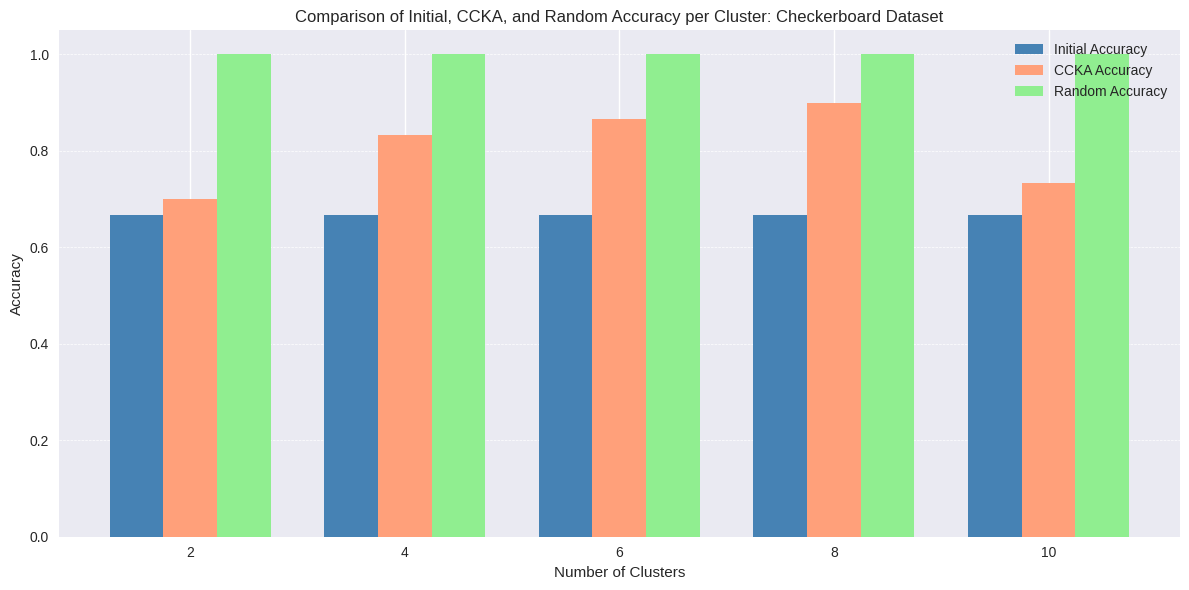

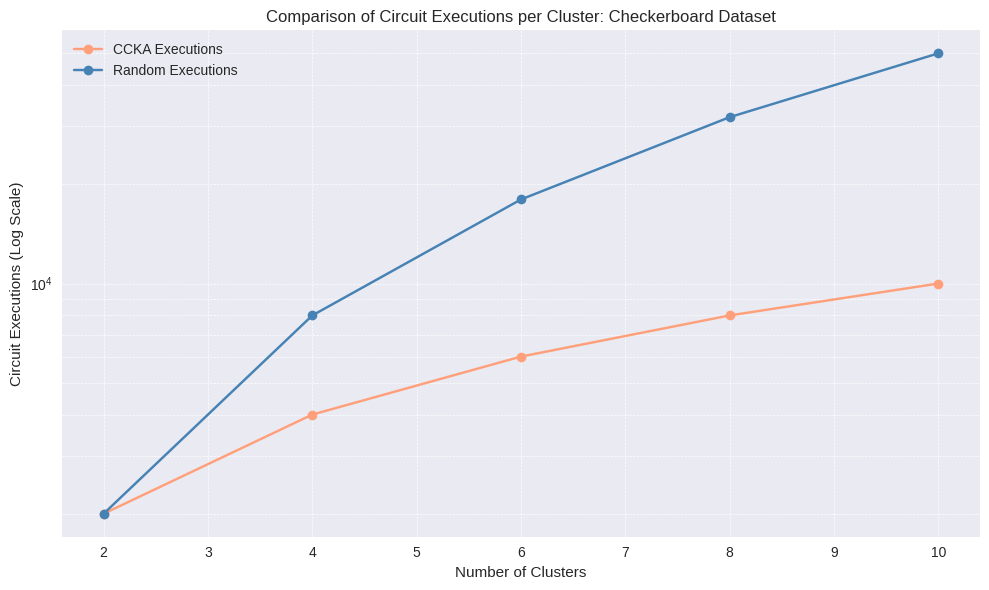

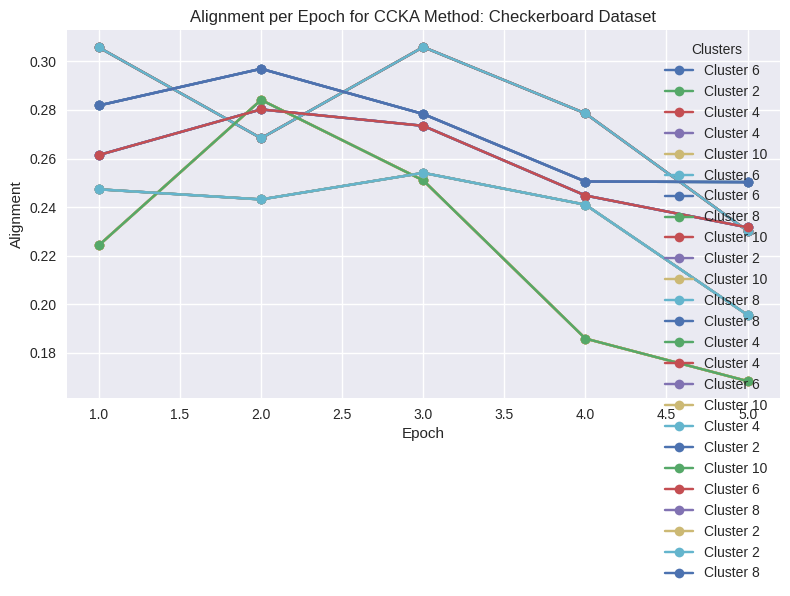

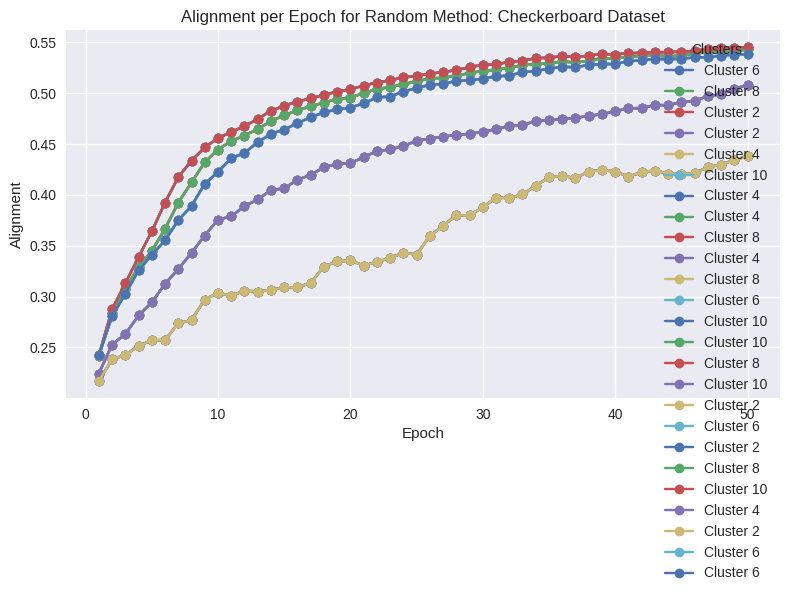

In [20]:
## Comparision per Algorithm : Checkerboard

# Plotting joint bar graph
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
#========================================#
#Accuracy
#========================================#

# Prepare data for plotting
clusters = [2, 4, 6, 8, 10]
initial_means = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'ccka']\
    .groupby('config.clusters')['accuracy_test_init'].mean()
ccka_means = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'ccka']\
    .groupby('config.clusters')['accuracy_test_final'].mean()
random_means = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'random']\
    .groupby('config.clusters')['accuracy_test_final'].mean()

cluster_indices = np.arange(len(clusters))  # Numeric indices for clusters
bar_width = 0.25  # Width of each bar

# Bars for Initial Accuracy
plt.bar(cluster_indices - bar_width, [initial_means.get(c, 0) for c in clusters], width=bar_width,
        label='Initial Accuracy', color='#4682b4')  # Light blue

# Bars for CCKA Accuracy
plt.bar(cluster_indices, [ccka_means.get(c, 0) for c in clusters], width=bar_width,
        label='CCKA Accuracy', color='#ffa07a')  # Salmon orange

# Bars for Random Accuracy
plt.bar(cluster_indices + bar_width, [random_means.get(c, 0) for c in clusters], width=bar_width,
        label='Random Accuracy', color='#90EE90')  # Light green

# Add labels, title, and legend
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy")
plt.title("Comparison of Initial, CCKA, and Random Accuracy per Cluster: Checkerboard Dataset")
plt.xticks(cluster_indices, clusters)  # Set cluster labels on x-axis
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

#========================================#
#Circuit Executions
#========================================#

# Convert the y-axis to a logarithmic scale for Circuit Executions
final_color = '#ffa07a'
initial_color = '#4682b4'
# Filter the data for different training methods
ccka = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'ccka']
random = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'random']

# Calculate mean circuit executions for ccka and random methods per cluster
ccka_means = ccka.groupby('config.clusters')['circuit_executions'].mean()
random_means = random.groupby('config.clusters')['circuit_executions'].mean()

# Plotting circuit executions for each method
plt.figure(figsize=(10, 6))
plt.plot(clusters, [ccka_means.get(c, None) for c in clusters], marker='o', label='CCKA Executions', color=final_color)
plt.plot(clusters, [random_means.get(c, None) for c in clusters], marker='o', label='Random Executions', color=initial_color)

# Add labels, title, and legend
plt.xlabel("Number of Clusters")
plt.ylabel("Circuit Executions (Log Scale)")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Comparison of Circuit Executions per Cluster: Checkerboard Dataset")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

#========================================#
#Alignments
#========================================#


# Filter data for each training method
ccka_epochs = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'ccka']
random_epochs = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'random']

# Line plot for alignment across epochs per cluster
for i, row in ccka_epochs.iterrows():
    plt.plot(range(1, len(row['alignment_train_epochs']) + 1), row['alignment_train_epochs'],
             marker='o', label=f"Cluster {int(row['config.clusters'])}")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Alignment")
plt.title("Alignment per Epoch for CCKA Method: Checkerboard Dataset")
plt.legend(title="Clusters")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Line plot for alignment across epochs per cluster
for i, row in random_epochs.iterrows():
    plt.plot(range(1, len(row['alignment_train_epochs']) + 1), row['alignment_train_epochs'],
             marker='o', label=f"Cluster {int(row['config.clusters'])}")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Alignment")
plt.title("Alignment per Epoch for Random Method: Checkerboard Dataset")
plt.legend(title="Clusters")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

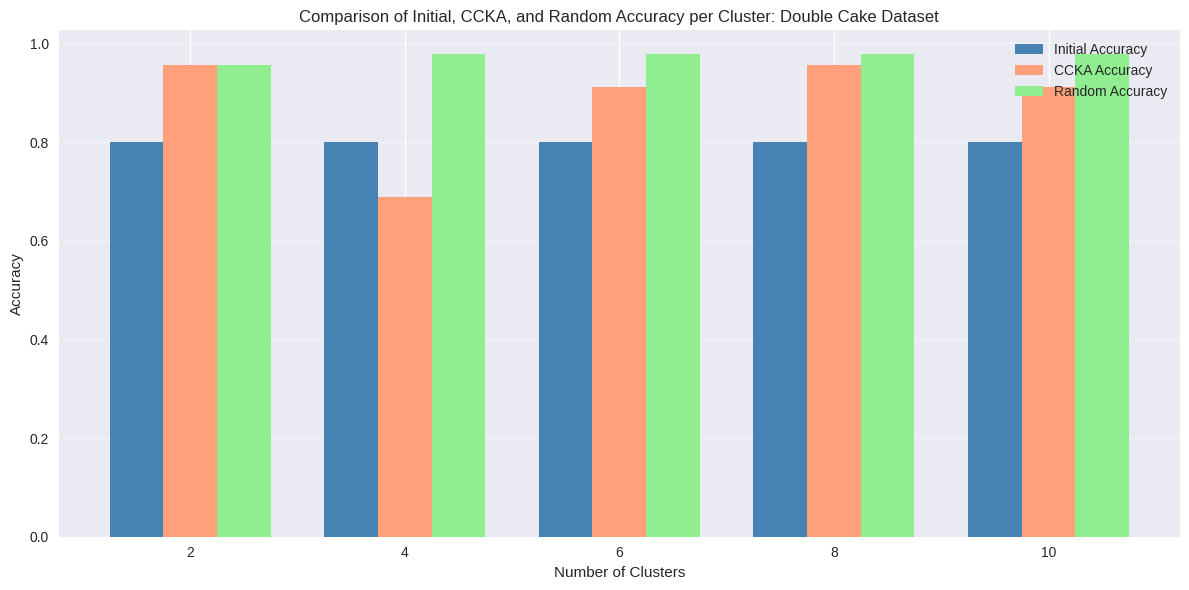

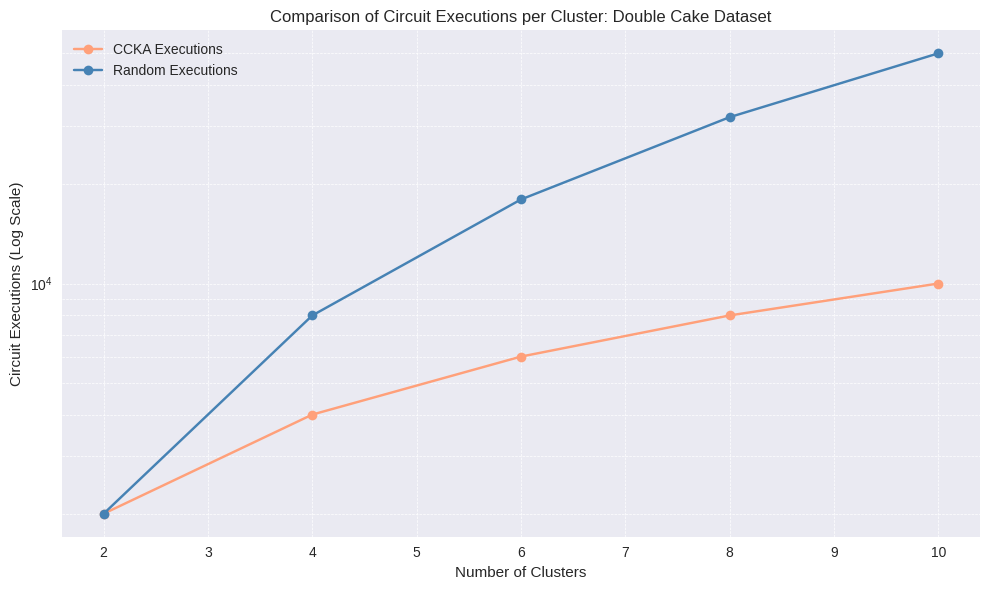

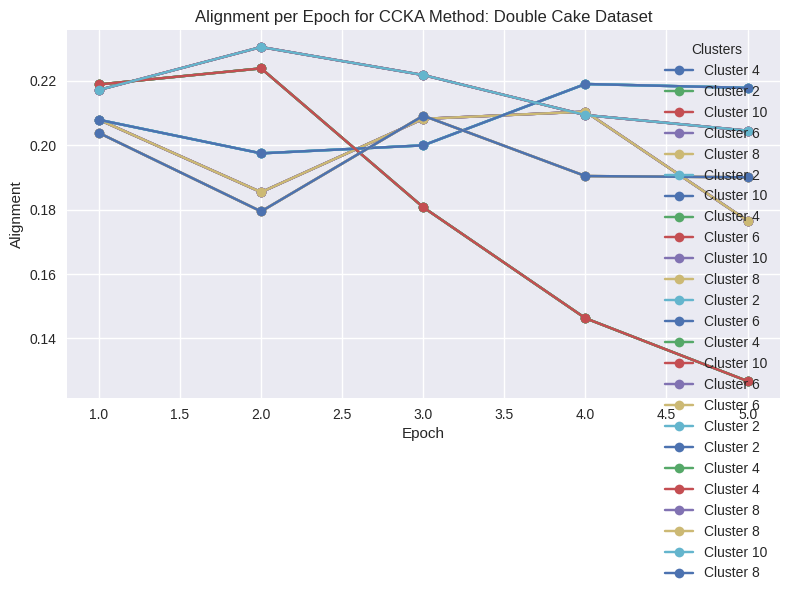

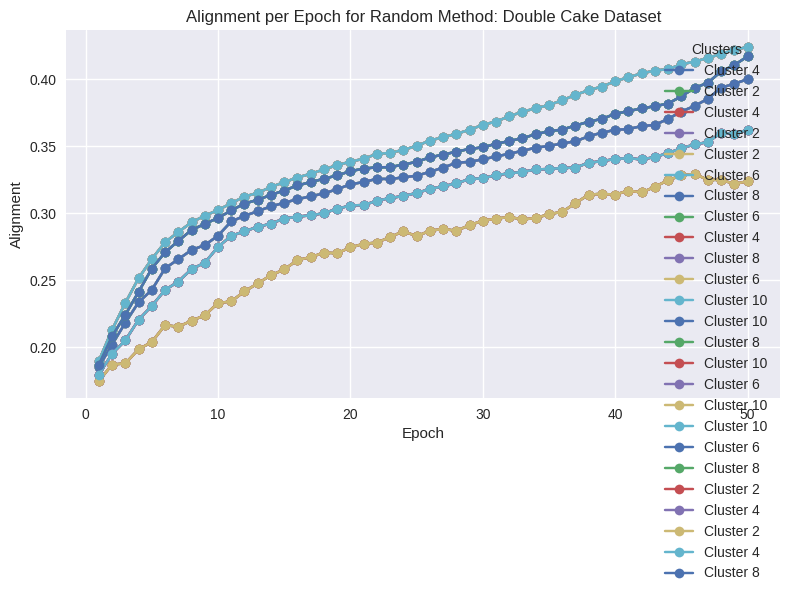

In [21]:
## Comparision per Algorithm : Double Cake

# Plotting joint bar graph
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
#========================================#
#Accuracy
#========================================#

# Prepare data for plotting
clusters = [2, 4, 6, 8, 10]
initial_means = results_01_double_cake[results_01_double_cake['config.train_method'] == 'ccka']\
    .groupby('config.clusters')['accuracy_test_init'].mean()
ccka_means = results_01_double_cake[results_01_double_cake['config.train_method'] == 'ccka']\
    .groupby('config.clusters')['accuracy_test_final'].mean()
random_means = results_01_double_cake[results_01_double_cake['config.train_method'] == 'random']\
    .groupby('config.clusters')['accuracy_test_final'].mean()

cluster_indices = np.arange(len(clusters))  # Numeric indices for clusters
bar_width = 0.25  # Width of each bar

# Bars for Initial Accuracy
plt.bar(cluster_indices - bar_width, [initial_means.get(c, 0) for c in clusters], width=bar_width,
        label='Initial Accuracy', color='#4682b4')  # Light blue

# Bars for CCKA Accuracy
plt.bar(cluster_indices, [ccka_means.get(c, 0) for c in clusters], width=bar_width,
        label='CCKA Accuracy', color='#ffa07a')  # Salmon orange

# Bars for Random Accuracy
plt.bar(cluster_indices + bar_width, [random_means.get(c, 0) for c in clusters], width=bar_width,
        label='Random Accuracy', color='#90EE90')  # Light green

# Add labels, title, and legend
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy")
plt.title("Comparison of Initial, CCKA, and Random Accuracy per Cluster: Double Cake Dataset")
plt.xticks(cluster_indices, clusters)  # Set cluster labels on x-axis
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

#========================================#
#Circuit Executions
#========================================#

# Convert the y-axis to a logarithmic scale for Circuit Executions

# Filter the data for different training methods
ccka = results_01_double_cake[results_01_double_cake['config.train_method'] == 'ccka']
random = results_01_double_cake[results_01_double_cake['config.train_method'] == 'random']

# Calculate mean circuit executions for ccka and random methods per cluster
ccka_means = ccka.groupby('config.clusters')['circuit_executions'].mean()
random_means = random.groupby('config.clusters')['circuit_executions'].mean()

# Plotting circuit executions for each method
plt.figure(figsize=(10, 6))
plt.plot(clusters, [ccka_means.get(c, None) for c in clusters], marker='o', label='CCKA Executions', color=final_color)
plt.plot(clusters, [random_means.get(c, None) for c in clusters], marker='o', label='Random Executions', color=initial_color)

# Add labels, title, and legend
plt.xlabel("Number of Clusters")
plt.ylabel("Circuit Executions (Log Scale)")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Comparison of Circuit Executions per Cluster: Double Cake Dataset")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

#========================================#
#Alignments
#========================================#


# Filter data for each training method
ccka_epochs = results_01_double_cake[results_01_double_cake['config.train_method'] == 'ccka']
random_epochs = results_01_double_cake[results_01_double_cake['config.train_method'] == 'random']

# Line plot for alignment across epochs per cluster
for i, row in ccka_epochs.iterrows():
    plt.plot(range(1, len(row['alignment_train_epochs']) + 1), row['alignment_train_epochs'],
             marker='o', label=f"Cluster {int(row['config.clusters'])}")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Alignment")
plt.title("Alignment per Epoch for CCKA Method: Double Cake Dataset")
plt.legend(title="Clusters")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Line plot for alignment across epochs per cluster
for i, row in random_epochs.iterrows():
    plt.plot(range(1, len(row['alignment_train_epochs']) + 1), row['alignment_train_epochs'],
             marker='o', label=f"Cluster {int(row['config.clusters'])}")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Alignment")
plt.title("Alignment per Epoch for Random Method: Double Cake Dataset")
plt.legend(title="Clusters")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

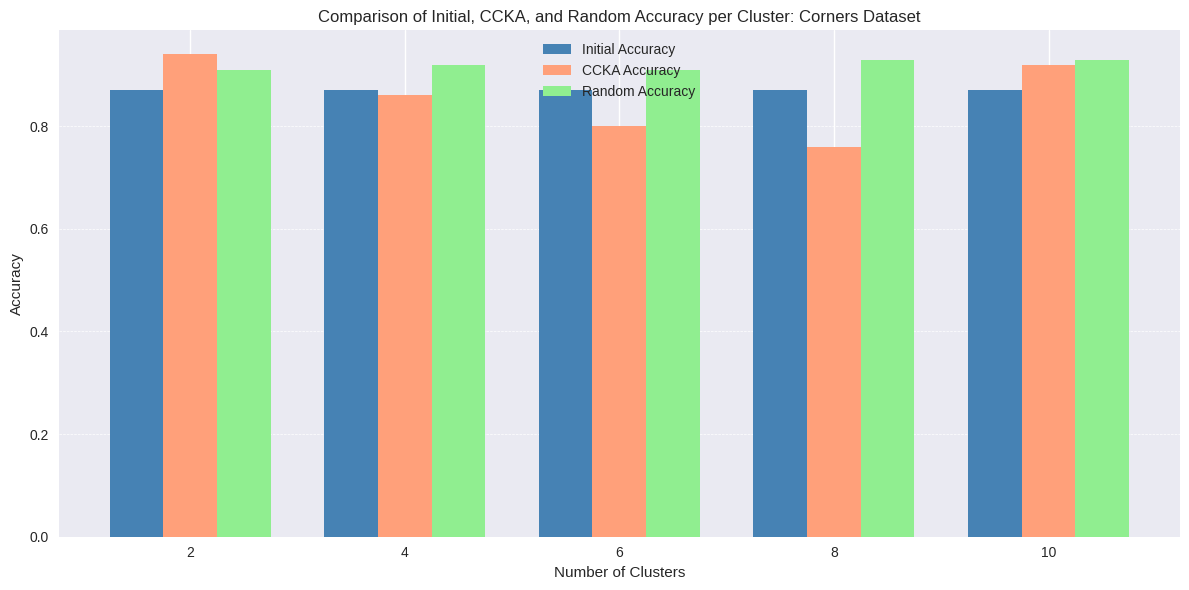

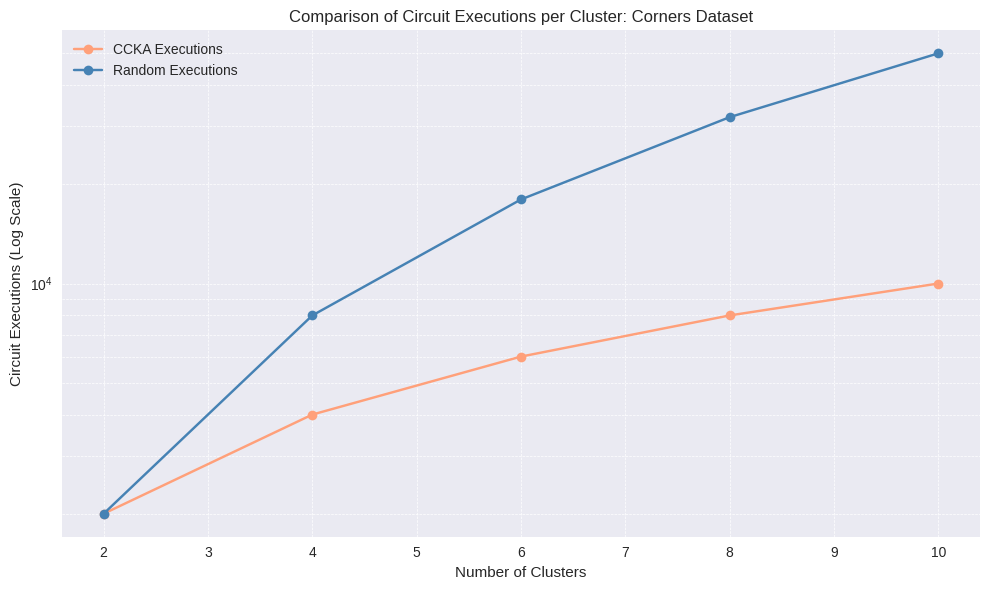

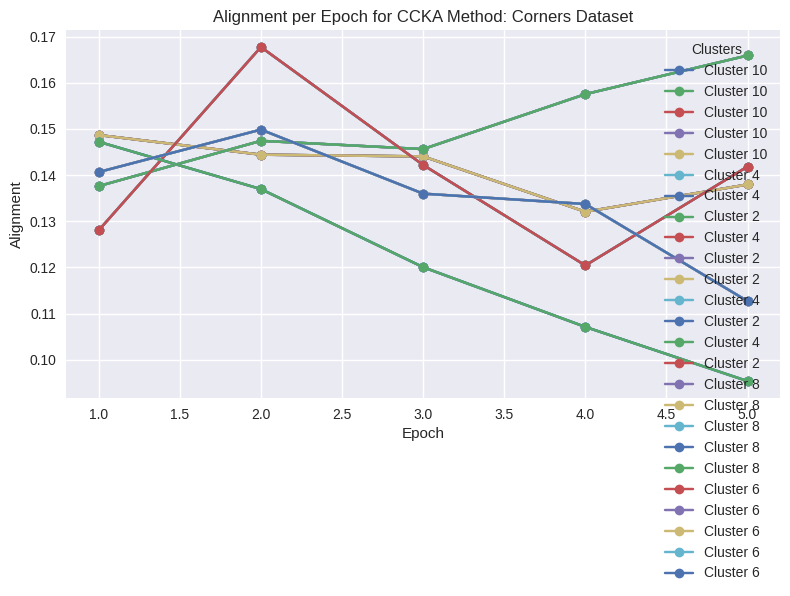

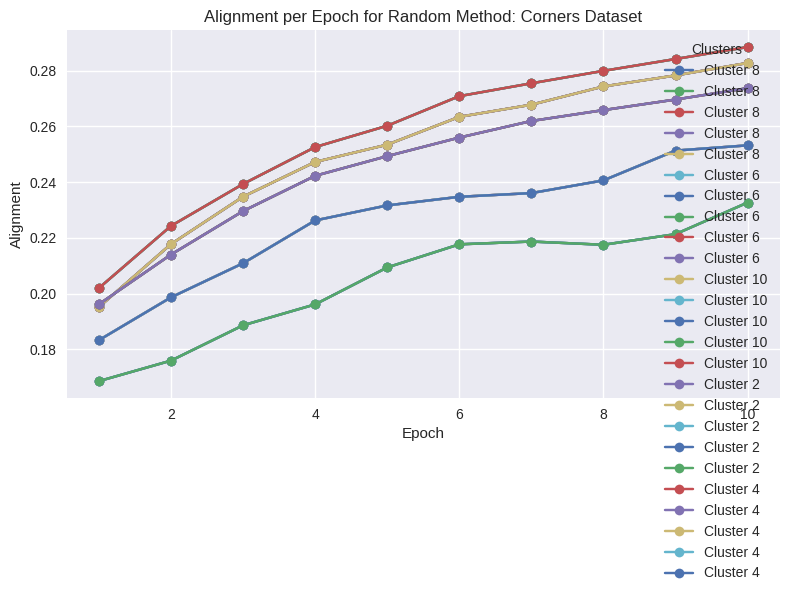

In [22]:
## Comparision per Algorithm : Corners

# Plotting joint bar graph
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
#========================================#
#Accuracy
#========================================#

# Prepare data for plotting
clusters = [2, 4, 6, 8, 10]
initial_means = results_01_corners[results_01_corners['config.train_method'] == 'ccka']\
    .groupby('config.clusters')['accuracy_test_init'].mean()
ccka_means = results_01_corners[results_01_corners['config.train_method'] == 'ccka']\
    .groupby('config.clusters')['accuracy_test_final'].mean()
random_means = results_01_corners[results_01_corners['config.train_method'] == 'random']\
    .groupby('config.clusters')['accuracy_test_final'].mean()

cluster_indices = np.arange(len(clusters))  # Numeric indices for clusters
bar_width = 0.25  # Width of each bar

# Bars for Initial Accuracy
plt.bar(cluster_indices - bar_width, [initial_means.get(c, 0) for c in clusters], width=bar_width,
        label='Initial Accuracy', color='#4682b4')  # Light blue

# Bars for CCKA Accuracy
plt.bar(cluster_indices, [ccka_means.get(c, 0) for c in clusters], width=bar_width,
        label='CCKA Accuracy', color='#ffa07a')  # Salmon orange

# Bars for Random Accuracy
plt.bar(cluster_indices + bar_width, [random_means.get(c, 0) for c in clusters], width=bar_width,
        label='Random Accuracy', color='#90EE90')  # Light green

# Add labels, title, and legend
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy")
plt.title("Comparison of Initial, CCKA, and Random Accuracy per Cluster: Corners Dataset")
plt.xticks(cluster_indices, clusters)  # Set cluster labels on x-axis
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

#========================================#
#Circuit Executions
#========================================#

# Convert the y-axis to a logarithmic scale for Circuit Executions

# Filter the data for different training methods
ccka = results_01_corners[results_01_corners['config.train_method'] == 'ccka']
random = results_01_corners[results_01_corners['config.train_method'] == 'random']

# Calculate mean circuit executions for ccka and random methods per cluster
ccka_means = ccka.groupby('config.clusters')['circuit_executions'].mean()
random_means = random.groupby('config.clusters')['circuit_executions'].mean()

# Plotting circuit executions for each method
plt.figure(figsize=(10, 6))
plt.plot(clusters, [ccka_means.get(c, None) for c in clusters], marker='o', label='CCKA Executions', color=final_color)
plt.plot(clusters, [random_means.get(c, None) for c in clusters], marker='o', label='Random Executions', color=initial_color)

# Add labels, title, and legend
plt.xlabel("Number of Clusters")
plt.ylabel("Circuit Executions (Log Scale)")
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Comparison of Circuit Executions per Cluster: Corners Dataset")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

#========================================#
#Alignments
#========================================#


# Filter data for each training method
ccka_epochs = results_01_corners[results_01_corners['config.train_method'] == 'ccka']
random_epochs = results_01_corners[results_01_corners['config.train_method'] == 'random']

# Line plot for alignment across epochs per cluster
for i, row in ccka_epochs.iterrows():
    plt.plot(range(1, len(row['alignment_train_epochs']) + 1), row['alignment_train_epochs'],
             marker='o', label=f"Cluster {int(row['config.clusters'])}")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Alignment")
plt.title("Alignment per Epoch for CCKA Method: Corners Dataset")
plt.legend(title="Clusters")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Line plot for alignment across epochs per cluster
for i, row in random_epochs.iterrows():
    plt.plot(range(1, len(row['alignment_train_epochs']) + 1), row['alignment_train_epochs'],
             marker='o', label=f"Cluster {int(row['config.clusters'])}")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Alignment")
plt.title("Alignment per Epoch for Random Method: Corners Dataset")
plt.legend(title="Clusters")
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

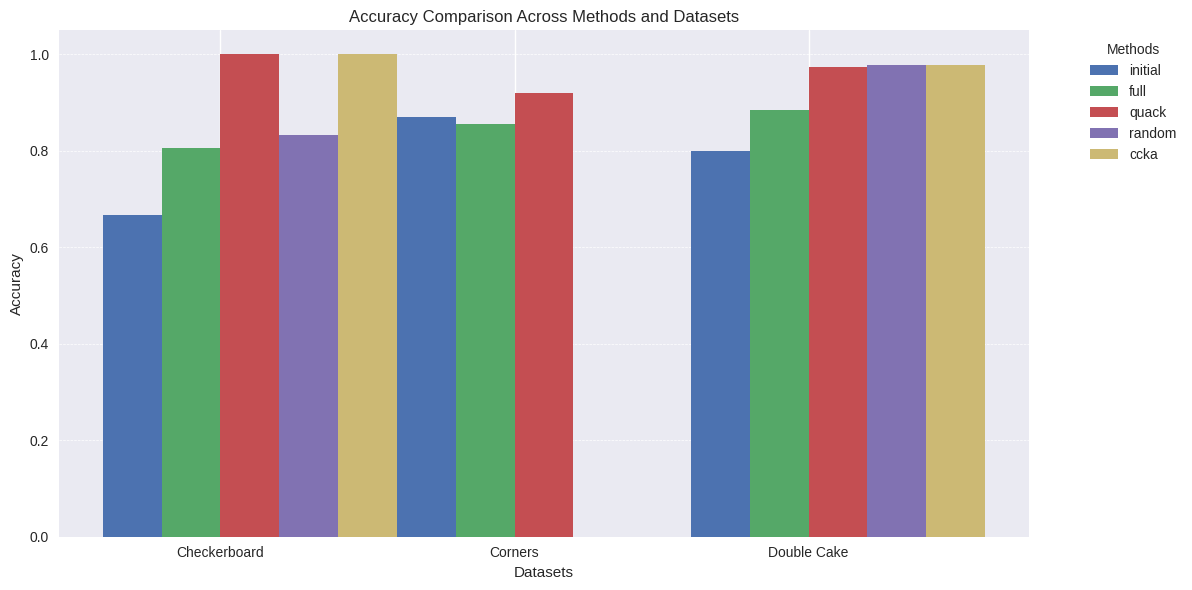

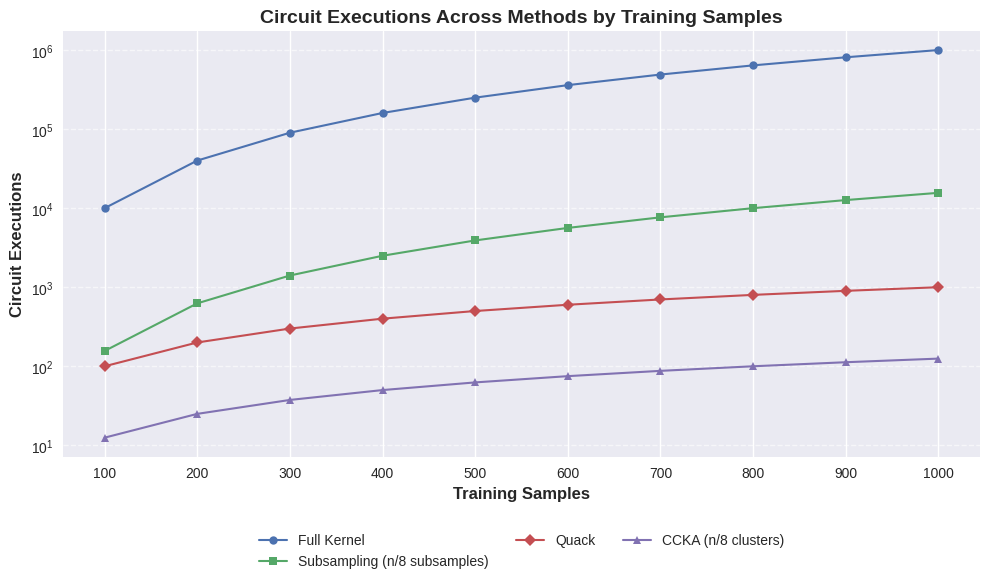

In [26]:
#Overall Comparisiom

#===============================
#Accuracy Comparision
#===============================

datasets = ['Checkerboard', 'Corners', 'Double Cake']
methods = ['initial', 'full', 'quack', 'random', 'ccka']

checkerboard_initial_means = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'ccka']['accuracy_test_init'].mean()
checkerboard_ccka_means = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'ccka']['accuracy_test_final'].mean()
checkerboard_random_means = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'random']['accuracy_test_final'].mean()
checkerboard_quack_means = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'quack']['accuracy_test_final'].mean()
checkerboard_full_means = results_01_checkerboard[results_01_checkerboard['config.train_method'] == 'full']['accuracy_test_final'].mean()

corners_initial_means = results_01_corners[results_01_corners['config.train_method'] == 'ccka']['accuracy_test_init'].mean()
corners_ccka_means = results_01_corners[results_01_corners['config.train_method'] == 'ccka']['accuracy_test_final'].mean()
corners_random_means = results_01_corners[results_01_corners['config.train_method'] == 'random']['accuracy_test_final'].mean()
corners_quack_means = results_01_corners[results_01_corners['config.train_method'] == 'quack']['accuracy_test_final'].mean()
corners_full_means = results_01_corners[results_01_corners['config.train_method'] == 'full']['accuracy_test_final'].mean()

double_cake_initial_means = results_01_double_cake[results_01_double_cake['config.train_method'] == 'ccka']['accuracy_test_init'].mean()
double_cake_ccka_means = results_01_double_cake[results_01_double_cake['config.train_method'] == 'ccka']['accuracy_test_final'].mean()
double_cake_random_means = results_01_double_cake[results_01_double_cake['config.train_method'] == 'random']['accuracy_test_final'].mean()
double_cake_quack_means = results_01_double_cake[results_01_double_cake['config.train_method'] == 'quack']['accuracy_test_final'].mean()
double_cake_full_means = results_01_double_cake[results_01_double_cake['config.train_method'] == 'full']['accuracy_test_final'].mean()


# Accuracy values for each dataset and method
accuracy_values = [
    [
        checkerboard_initial_means,
        checkerboard_ccka_means,
        checkerboard_random_means,
        checkerboard_quack_means,
        checkerboard_full_means,
    ],
    [
        corners_initial_means,
        corners_ccka_means,
        corners_random_means,
        corners_quack_means,
        corners_full_means,
    ],
    [
        double_cake_initial_means,
        double_cake_ccka_means,
        double_cake_random_means,
        double_cake_quack_means,
        double_cake_full_means,
    ],
]

# Plotting
x = np.arange(len(datasets))  # Dataset indices
bar_width = 0.2

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))

# Plot bars for each method
for i, method in enumerate(methods):
    plt.bar(x + i * bar_width, [dataset[i] for dataset in accuracy_values], width=bar_width, label=method)

# Add labels, title, and legend
plt.xlabel("Datasets")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Methods and Datasets")
plt.xticks(x + 1.5 * bar_width, datasets)  # Center dataset labels

plt.grid(axis='y', linestyle='--', linewidth=0.5)
# Place the legend outside the chart
plt.legend(title="Methods", loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust layout for better fit
plt.tight_layout()
# Display the plot
plt.show()


#===============================
#Accuracy Comparision
#===============================

# Data for clusters and average executions
clusters = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
avg_executions = [
    clusters * clusters,     # Full Kernel
    clusters/8 * clusters/8, # Subsampling for n/8 subsamples
    clusters,                 # Quack
    clusters/8               #CCKA for n/8 subsamples
]

# Labels and markers
methods = ['Full Kernel', 'Subsampling (n/8 subsamples)', 'Quack', 'CCKA (n/8 clusters)']
markers = ['o', 's', 'D', '^']
# Updated plot with continuous x-axis ticks from 100 to 1000
fig, ax = plt.subplots(figsize=(10, 6))

for i, method in enumerate(methods):
    ax.plot(
        clusters,
        avg_executions[i],
        label=f"{method}",
        marker=markers[i % len(markers)],
        markersize=6,
        linewidth=2
    )

# Set labels and title
ax.set_xlabel("Training Samples", fontsize=12, fontweight='bold')
ax.set_ylabel("Circuit Executions", fontsize=12, fontweight='bold')
ax.set_title("Circuit Executions Across Methods by Training Samples", fontsize=14, fontweight='bold')

# Use logarithmic scale for the y-axis
ax.set_yscale('log')

# Set continuous x-axis ticks
ax.set_xticks(clusters)

# Customize grid and legend
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Position the legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

plt.tight_layout()
plt.show()
fig.savefig("circuit_executions_high_def.png", dpi=300, bbox_inches="tight")
